In [2]:
#!pip install shap
#!pip install dalex

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dalex as dx
print(dx.__version__)

1.6.0


## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*



- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)* OK
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)* OK
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)* OK

MENTAL HEALTH 

- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*

CONTRY

- **PreviousSalary**: the applicant's previous job salary *(float)*

HAVE WORK WITH

- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


MentalHealth       object
Country            object
Accessibility      object
HaveWorkedWith     object
Employment          int64


# ENREGISTREMENT DES IDEES TESTES

In [4]:
# Documentez les changements
changes_log = {
    'data_preprocessing': 'Implemented re-sampling to balance gender representation',
    'model_adjustment': 'Switched to FairLearningAlgorithm with bias mitigation',
    #'audit_results': group_metrics.to_dict(),
    # ...
}

# Écrivez le log des changements dans un fichier ou un système de suivi
with open('changes_log.txt', 'w') as log_file:
    for key, value in changes_log.items():
        log_file.write(f"{key}: {value}\n")


# Preprocessing des données

In [5]:
import pandas as pd
data = pd.read_csv("stackoverflow_full.csv")

# Supprimer la colonne 'Unnamed: 0' si elle est inutile
data.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:

df = data
def convert_column_types(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = df[column].unique()
            
            # Si toutes les valeurs sont des entiers
            if all(val.isdigit() for val in unique_values):
                df[column] = df[column].astype(int)
            # Si toutes les valeurs sont des nombres flottants
            elif all(val.replace('.', '', 1).isdigit() for val in unique_values):
                df[column] = df[column].astype(float)
            # Sinon, convertir en chaînes de caractères
            else:    
                df[column] = df[column].astype(str)

    return df

# Convertir les colonnes
df_converted = convert_column_types(df)

# Afficher les types de données après conversion
print(df_converted.dtypes)

Age                object
Accessibility      object
EdLevel            object
Employment          int64
Gender             object
MentalHealth       object
MainBranch         object
YearsCode           int64
YearsCodePro        int64
Country            object
PreviousSalary    float64
HaveWorkedWith     object
ComputerSkills      int64
Employed            int64
dtype: object


## Exploratory Data Analysis


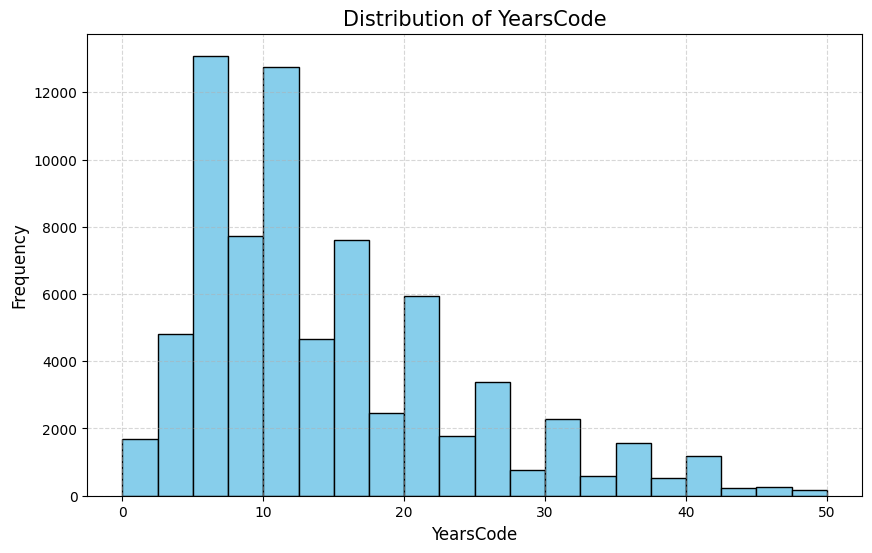

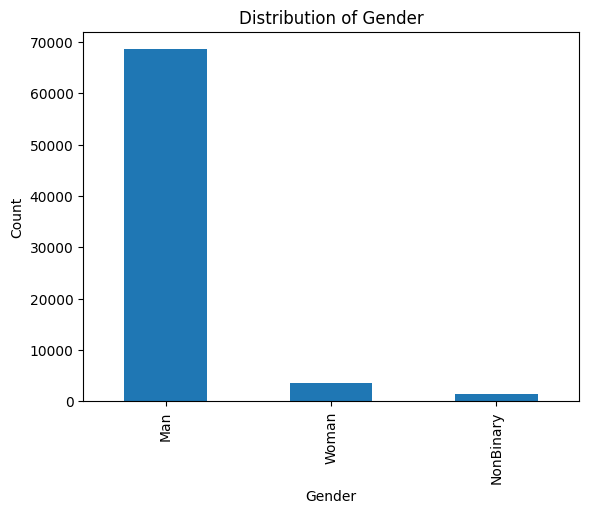

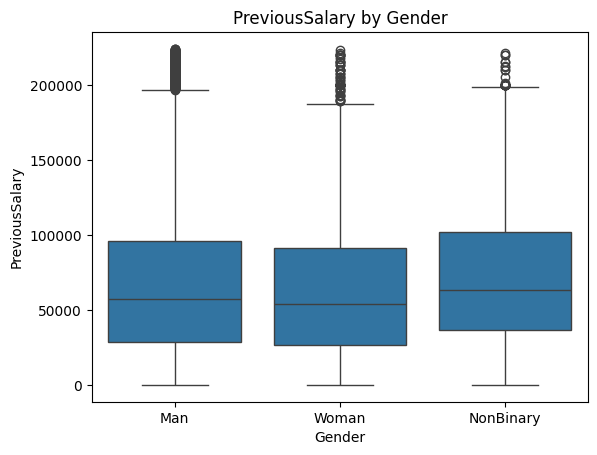

In [7]:
# Histogramme pour 'YearsCode'
plt.figure(figsize=(10, 6))  # Augmente la taille du graphique
plt.hist(data['YearsCode'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of YearsCode', fontsize=15)
plt.xlabel('YearsCode', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Diagramme en barres pour une variable catégorielle, par exemple 'Gender'
data['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


# Boxplot pour comparer 'PreviousSalary' par 'Gender'
sns.boxplot(x='Gender', y='PreviousSalary', data=data)
plt.title('PreviousSalary by Gender')
plt.show()



C:\Users\choho\AppData\Local\Temp\ipykernel_10888\3878827074.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


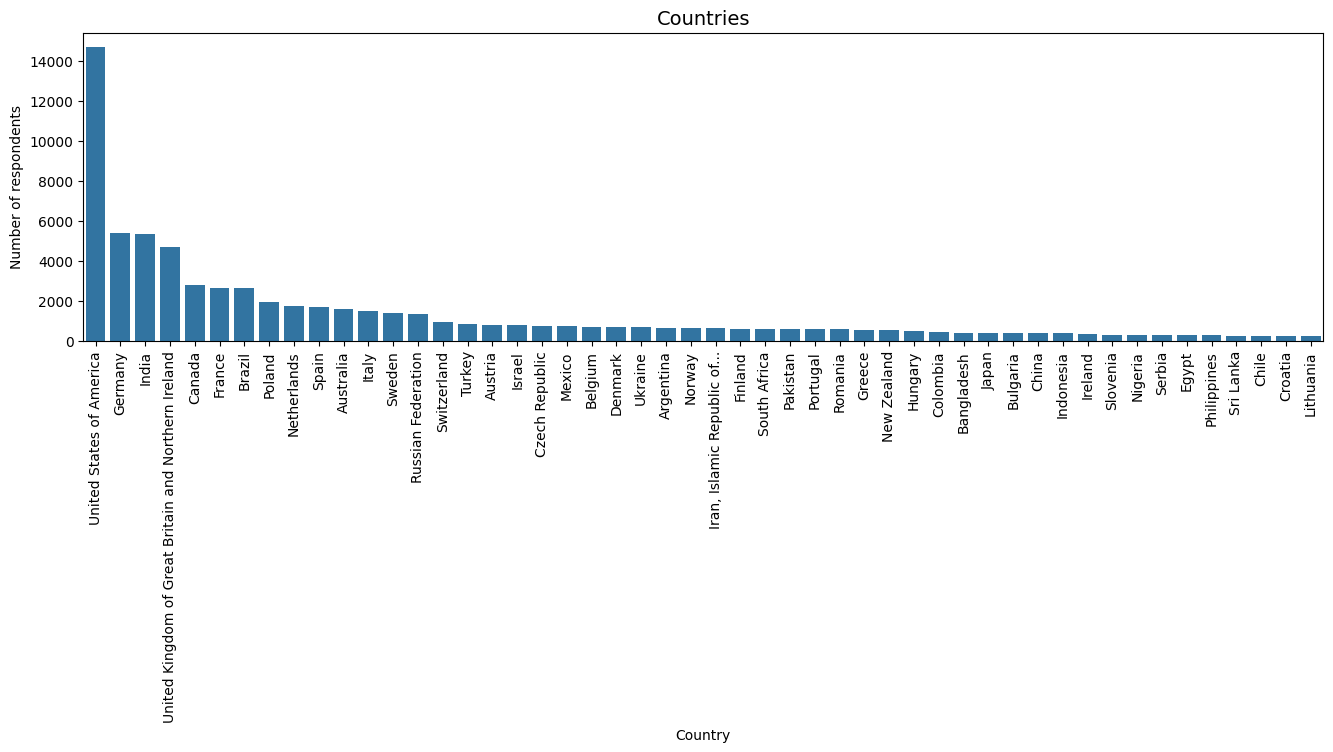

In [8]:
def plot_stats(feature, text, size=2):
    temp = data[feature].dropna().value_counts().head(50)
    df1 = pd.DataFrame({feature: temp.index,'Number of respondents': temp.values})
    plt.figure(figsize = (8*size,4))
    plt.title(text,fontsize=14)
    s = sns.barplot(x=feature,y='Number of respondents',data=df1)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()   
    
plot_stats('Country','Countries')

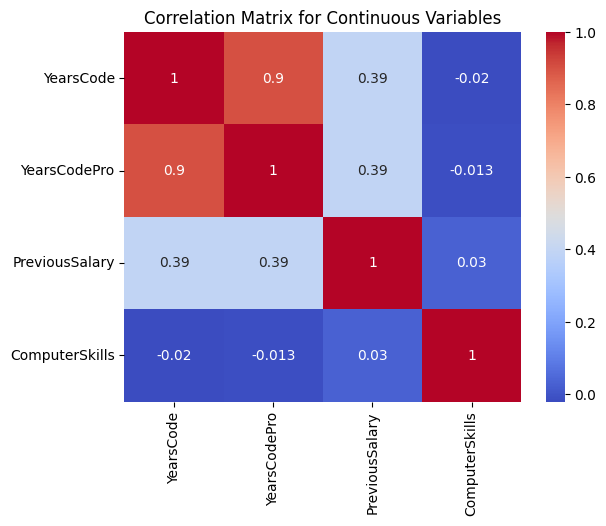

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Sélectionner uniquement les variables continues
continuous_vars = ['YearsCode', 'YearsCodePro', 'PreviousSalary','ComputerSkills']

# Calculer la matrice de corrélation pour les variables continues
corr = data[continuous_vars].corr()

# Créer une heatmap pour visualiser la matrice de corrélation
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Continuous Variables')
plt.show()


# Baseline modelisation

In [13]:
# Encodage One-Hot pour les caractéristiques catégorielles
data  = pd.get_dummies(data, columns=['Gender'])
data  = pd.get_dummies(data, columns=['EdLevel'])

# Création d'un dictionnaire pour le mappage ordinal
#mapping_edlevel = {
#    'NoHigherEd': 0,       # Pas d'éducation supérieure
#    'Undergraduate': 1,    # Niveau Licence
#    'Master': 2,           # Master
#    'PhD': 3,              # Doctorat
#    'Other': 4             # Autre
#}

# Encodage ordinal de la colonne 'EdLevel'
#data['EdLevel_Ordinal'] = data['EdLevel'].map(mapping_edlevel)

# Création d'un dictionnaire pour le mappage ordinal
mapping_mainbranch = {
    'NotDev': 0,      # Développeur
    'Dev': 1    # Non développeur
}

# Encodage ordinal de la colonne 'MainBranch'
data['MainBranch_encoded'] = data['MainBranch'].map(mapping_mainbranch)

# Création d'un dictionnaire pour le mappage ordinal
mapping_age = {
    '<35': 0,    # Moins de 35 ans
    '>35': 1     # Plus de 35 ans
}

# Encodage ordinal de la colonne 'Age'
data['Age_encoded'] = data['Age'].map(mapping_age)



# Création d'un dictionnaire pour le mappage ordinal
mapping_MentalHealth= {
    'Yes': 0,    # yes
    'No': 1     # no
}

# Encodage ordinal de la colonne 'Age'
data['MentalHealth_encoded'] = data['MentalHealth'].map(mapping_MentalHealth)


In [14]:
data

,Age,Accessibility,Employment,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,...,Gender_NonBinary,Gender_Woman,EdLevel_Master,EdLevel_NoHigherEd,EdLevel_Other,EdLevel_PhD,EdLevel_Undergraduate,MainBranch_encoded,Age_encoded,MentalHealth_encoded
0,<35,No,1,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,...,False,False,True,False,False,False,False,1,0,1
1,<35,No,1,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,...,False,False,False,False,False,False,True,1,0,1
2,<35,No,1,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,...,False,False,True,False,False,False,False,1,0,1
3,<35,No,1,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,...,False,False,False,False,False,False,True,1,0,1
4,>35,No,0,No,NotDev,40,30,Singapore,160932.0,C++;Python,...,False,False,False,False,False,True,False,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73457,<35,No,1,No,Dev,7,2,Germany,41058.0,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...,...,False,False,False,False,False,False,True,1,0,1
73458,>35,No,1,No,Dev,21,16,United States of America,115000.0,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...,...,False,False,False,False,False,False,True,1,1,1
73459,<35,No,1,No,Dev,4,3,Nigeria,57720.0,HTML/CSS;JavaScript;TypeScript;Docker;Express;...,...,False,False,False,False,False,False,True,1,0,1
73460,<35,Yes,1,Yes,Dev,5,1,United States of America,70000.0,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...,...,False,False,False,False,False,False,True,1,0,0


In [24]:
from sklearn.preprocessing import MinMaxScaler

# Variables continues et qualitatives
continuous_vars = ['YearsCode', 'YearsCodePro', 'PreviousSalary','ComputerSkills']
qualitative_vars = ['Age_encoded', 'MentalHealth_encoded', 'MainBranch_encoded', "Gender_Man", "Gender_NonBinary", "Gender_Woman", "EdLevel_Master", "EdLevel_NoHigherEd", "EdLevel_Other", "EdLevel_PhD", "EdLevel_Undergraduate"]
target = ['Employed']

# Sélection des colonnes dans le DataFrame
X_continuous = data[continuous_vars]
X_qualitative = data[qualitative_vars]
y = data[target]

# Standardisation des variables continues
scaler = MinMaxScaler()
X_continuous_scaled = scaler.fit_transform(X_continuous)

# Conversion en DataFrame
X_continuous_scaled = pd.DataFrame(X_continuous_scaled, columns=continuous_vars, index=data.index)

# Combinaison des variables continues standardisées et qualitatives
X = pd.concat([X_continuous_scaled, X_qualitative], axis=1)


## Modeling

# PLAN A SUIVRE

# CREATION DE VARIABLES 

idée : creer des polynomial feature

### techniques de reechantillonage
- oversampling
- undersampling
- adasyn
- smote
- etc


### Découpage de la base
    - base de train
    - base de test 

### modèle de classification : y = target == > employé ou pas employé
- modèles d'arbre de décision
    - Decision Tree    
    - Random RandomForestClassifier
    - adaboost 
    - Xgboost
    - Catboost
    - LightGBM

- modèle ensembliste 
    - Bagging
    - Boosting
    - stacking
    - Voting Classifier
    
- Modèle de Deep Learning
    -MLP classification
    -le reste

 PS : hyperparametre weight = class_weight = 'balanced"
 PS 2 : n_jobs = -1  --> permet d'accelerer le temps de calcul


### gestion des hyperparametre 
grid search CV
PS : voir la cross-validation


# Voir les variables importantes
- features importances (déjà codé avec une librairie appelée Scikit learn )
- valeur de shappley : library python shap, LIME, etc


### fairness

1ère définition
- performance du modèle chez les hommes
- performance du modèle chez les femmes
- performance du modèle chez les non binary

2ème définition
- prédire plus les hommes que les femmes


In [28]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_fscore_support
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pandas as pd

# Splitting de la base
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Définition des modèles
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_logreg = LogisticRegression()  # LogisticRegression ne supporte pas n_jobs
clf_dt = DecisionTreeClassifier()  # DecisionTreeClassifier ne supporte pas n_jobs
clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_adaboost = AdaBoostClassifier()  # AdaBoostClassifier ne supporte pas n_jobs
clf_xgb = xgb.XGBClassifier(n_jobs=-1)
clf_lgb = lgb.LGBMClassifier(n_jobs=-1)
clf_catboost = cb.CatBoostClassifier(verbose=0, thread_count=-1) # 'verbose=0' pour réduire la sortie du journal



# Grilles d'hyperparamètres
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [5,7,10]}
param_grid_logreg = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'saga']}
param_grid_dt = {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
param_grid_adaboost = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [3, 4, 5]}
param_grid_lgb = {'n_estimators': [100, 200], 'max_depth': [3, 5, 6]}
param_grid_catboost = {'iterations': [100, 200], 'depth': [4, 6, 8]}

# Dictionnaire de modèles et leurs grilles d'hyperparamètres
models = {
    'RandomForest': (clf_rf, param_grid_rf),
   'LogisticRegression': (clf_logreg, param_grid_logreg),
    'DecisionTree': (clf_dt, param_grid_dt),
    'KNN': (clf_knn, param_grid_knn),
    'AdaBoost': (clf_adaboost, param_grid_adaboost),
    'XGBoost': (clf_xgb, param_grid_xgb),
    'LightGBM': (clf_lgb, param_grid_lgb),
    'CatBoost': (clf_catboost, param_grid_catboost)
}

# Dictionnaire pour stocker les meilleurs modèles et leurs paramètres
best_models = {}

# Création d'un DataFrame pour stocker les résultats
results_df = pd.DataFrame()

# Tuning des hyperparamètres et évaluation des modèles
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train.values.ravel())
    best_model = grid_search.best_estimator_
    
    # Stockage du meilleur modèle et de ses paramètres
    best_models[model_name] = best_model

    y_pred_test = best_model.predict(X_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_test)

    # Création d'un DataFrame temporaire pour stocker les résultats pour ce modèle
    temp_df = pd.DataFrame({
        'Model': model_name,
        'Class': [0, 1],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': fscore,
        'Support': support,
        'Best Parameters': str(grid_search.best_params_)
    })

    # Ajout des résultats au DataFrame principal
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Affichage du DataFrame
print(results_df)

# Affichage des meilleurs modèles et de leurs paramètres
for model_name, model in best_models.items():
    print(f"{model_name} Best Parameters: {model.get_params()}")


          Model  Class  Precision    Recall  F1-Score  Support  \
0  RandomForest      0   0.782568  0.739883  0.760627     6820   
1  RandomForest      1   0.784839  0.821923  0.802953     7873   
2           KNN      0   0.722230  0.712170  0.717165     6820   
3           KNN      1   0.753640  0.762733  0.758159     7873   

                            Best Parameters  
0    {'max_depth': 10, 'n_estimators': 300}  
1    {'max_depth': 10, 'n_estimators': 300}  
2  {'n_neighbors': 7, 'weights': 'uniform'}  
3  {'n_neighbors': 7, 'weights': 'uniform'}  
RandomForest Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
KNN Best Parameters:

In [30]:
from sklearn.dummy import DummyClassifier


# Création d'un DummyClassifier qui prédit toujours la classe 1
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(X_train, y_train)  # Note: l'entraînement n'a pas vraiment d'effet ici

# Fonction pour ajuster les prédictions
def custom_predict(X):
    # Récupérer les prédictions du dummy classifier
    predictions = dummy_clf.predict(X)

    # Ajuster les prédictions en fonction de la variable 'Gender_Man'
    is_man = X['Gender_Man'] == True
    predictions[~is_man] = 0  # Mettre à 0 pour les observations où 'Gender_Man' n'est pas True

    return predictions


# Définissez d'abord le nom du modèle pour l'utiliser dans le DataFrame
model_name = 'CustomDummy'

# Faites les prédictions personnalisées
y_pred_train_custom = custom_predict(X_train)
y_pred_test_custom = custom_predict(X_test)

# Calculer les métriques pour l'ensemble d'entraînement
precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(y_train, y_pred_train_custom)

# Calculer les métriques pour l'ensemble de test
precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(y_test, y_pred_test_custom)


# Ajouter les résultats du test au DataFrame
temp_test_df = pd.DataFrame({
    'Model': model_name,
    'Set': 'Test',
    'Class': [0, 1],
    'Precision': precision_test,
    'Recall': recall_test,
    'F1-Score': fscore_test,
    'Support': support_test
})

# Concaténer avec le DataFrame principal
results_df = pd.concat([results_df, temp_test_df], ignore_index=True)

# Afficher le DataFrame mis à jour
print(results_df)


          Model  Class  Precision    Recall  F1-Score  Support  \
0  RandomForest      0   0.782568  0.739883  0.760627     6820   
1  RandomForest      1   0.784839  0.821923  0.802953     7873   
2           KNN      0   0.722230  0.712170  0.717165     6820   
3           KNN      1   0.753640  0.762733  0.758159     7873   
4   CustomDummy      0   0.527128  0.075229  0.131668    27250   
5   CustomDummy      1   0.540816  0.941654  0.687045    31519   
6   CustomDummy      0   0.529000  0.077566  0.135294     6820   
7   CustomDummy      1   0.540568  0.940175  0.686451     7873   
8   CustomDummy      0   0.529000  0.077566  0.135294     6820   
9   CustomDummy      1   0.540568  0.940175  0.686451     7873   

                            Best Parameters    Set  
0    {'max_depth': 10, 'n_estimators': 300}    NaN  
1    {'max_depth': 10, 'n_estimators': 300}    NaN  
2  {'n_neighbors': 7, 'weights': 'uniform'}    NaN  
3  {'n_neighbors': 7, 'weights': 'uniform'}    NaN  
4       

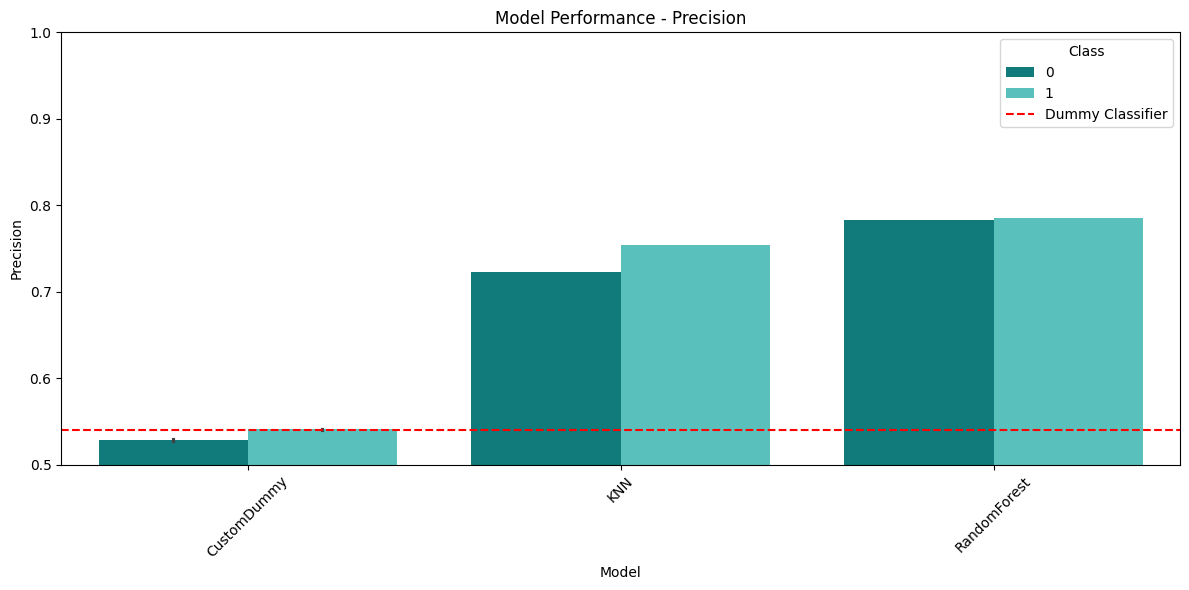

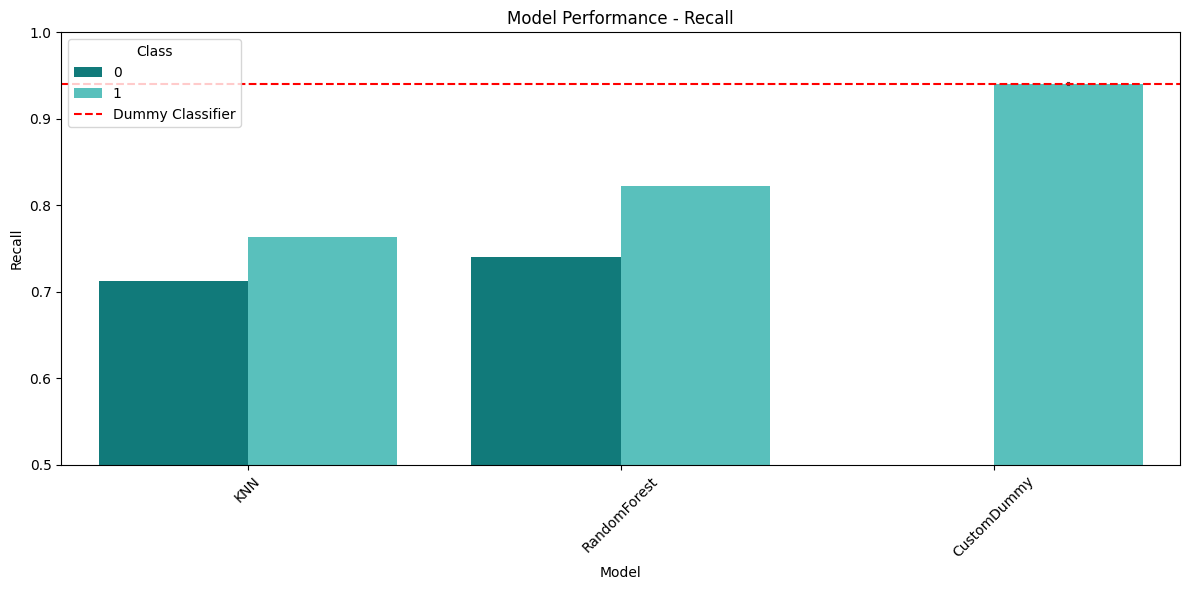

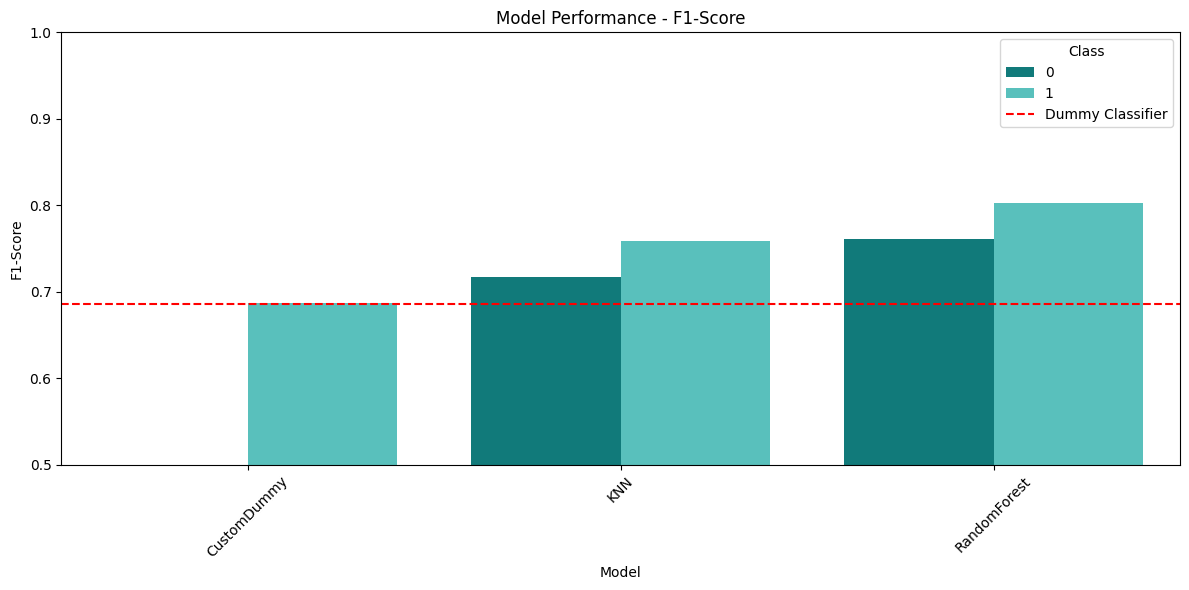

In [31]:
# Ajouter les résultats du Dummy Classifier dans le DataFrame
dummy_data = {
    'Model': ['CustomDummy', 'CustomDummy'],
    'Class': [0, 1],
    'Precision': [0.526892, 0.540507],
    'Recall': [0.077577, 0.939675],
    'F1-Score': [0.135242, 0.686268],
    'Support': [6819, 7874],
    'Set': ['Test', 'Test']
}
dummy_df = pd.DataFrame(dummy_data)
results_df_with_dummy = pd.concat([results_df, dummy_df], ignore_index=True)

# Tracer un graphique pour chaque métrique (Precision, Recall, F1-Score), en triant les modèles et en ajoutant une ligne rouge pour le Dummy Classifier
for metric in ['Precision', 'Recall', 'F1-Score']:
    plt.figure(figsize=(12, 6))

    # Trier les données en fonction de la métrique choisie pour la classe 1
    sorted_data = results_df_with_dummy[results_df_with_dummy['Class'] == 1].sort_values(by=metric)

    # Tracer les barres pour tous les modèles
    sns.barplot(x='Model', y=metric, hue='Class', data=results_df_with_dummy, order=sorted_data['Model'], palette=['darkcyan', 'mediumturquoise'])
    
    # Ajouter une ligne rouge pour le Dummy Classifier
    dummy_metric = dummy_df[dummy_df['Class'] == 1][metric].values[0]
    plt.axhline(y=dummy_metric, color='red', linestyle='--', label='Dummy Classifier')

    plt.title(f'Model Performance - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Class')

    # Définir les limites de l'axe des y
    plt.ylim(0.5, 1)

    plt.tight_layout()
    plt.show()



In [66]:
# Assignation de chaque modèle à une variable
rf = best_models['RandomForest']
logreg = best_models['LogisticRegression']
dt = best_models['DecisionTree']
knn = best_models['KNN']
adaboost = best_models['AdaBoost']
xgb_model = best_models['XGBoost']
lgb_model = best_models['LightGBM']
catboost = best_models['CatBoost']


In [34]:
rf = best_models['RandomForest']


C:\Users\choho\AppData\Local\Temp\ipykernel_10888\3265587403.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=features, palette=custom_color)
C:\Users\choho\AppData\Local\Temp\ipykernel_10888\3265587403.py:12: UserWarning: 
The palette list has fewer values (1) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="Importance", y="Feature", data=features, palette=custom_color)


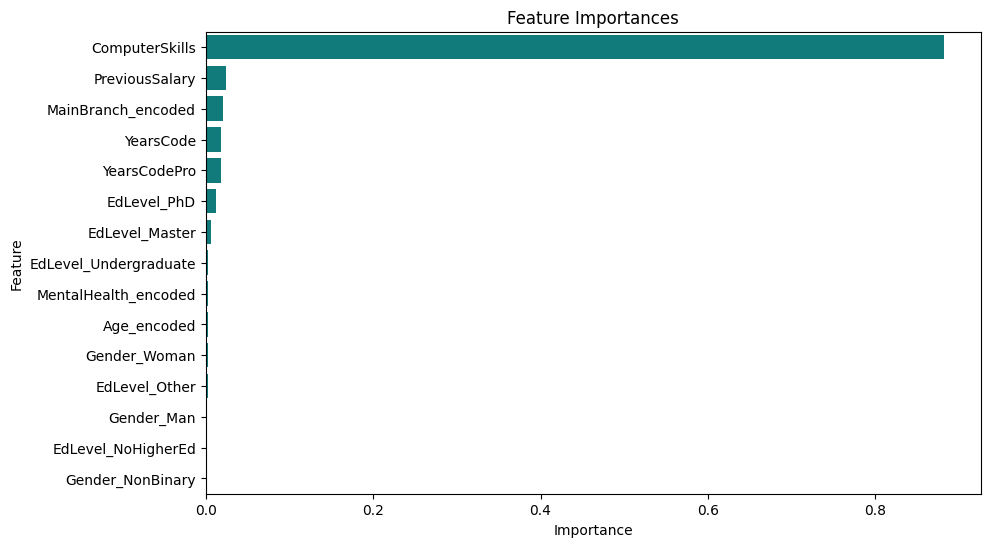

In [35]:

# Créer un DataFrame pour les importances des variables avec leurs labels
features = pd.DataFrame({'Feature': X_test.columns, 'Importance': rf.feature_importances_})

# Trier les features selon leur importance
features = features.sort_values(by='Importance', ascending=False)

# Définir la couleur personnalisée blackcyan
custom_color = sns.color_palette(["#008b8b"])  # blackcyan color

# Tracer l'importance des variables avec la couleur personnalisée
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=features, palette=custom_color)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


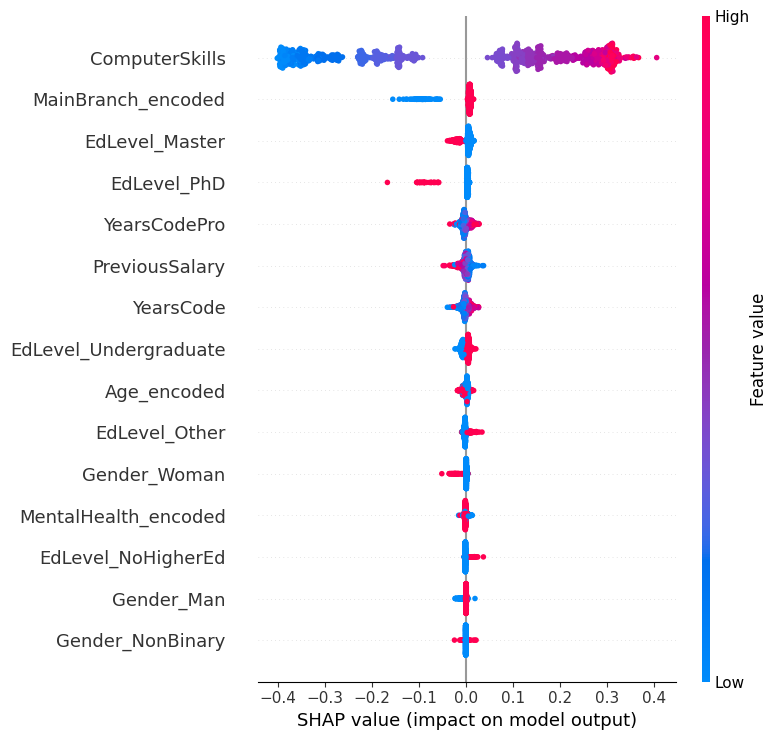

In [38]:
import shap

# Assurez-vous que le modèle RandomForestClassifier (clf_rf) est déjà entraîné

# Prendre un échantillon aléatoire de vos données d'entraînement pour le calcul SHAP
sample_size = 1000  # Définir la taille de l'échantillon selon vos besoins
X_train_sample = X_train.sample(sample_size, random_state=42)

# Calculer les valeurs SHAP sur l'échantillon
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_train_sample)

# Gérer le cas de la classification binaire
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # ou 0 pour la classe négative

# Créer un SHAP summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train_sample)


In [43]:
import shap

# Assurez-vous que le modèle RandomForestClassifier (clf_rf) est déjà entraîné

# Prendre un échantillon aléatoire de vos données d'entraînement pour le calcul SHAP
sample_size = 1000
X_train_sample = X_train.sample(sample_size, random_state=42)

# Calculer les valeurs SHAP sur l'échantillon
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(X_train_sample)

# Sélectionner les valeurs SHAP pour la classe positive (ou négative si nécessaire)
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Ici, 1 pour la classe positive
else:
    shap_values_class = shap_values

# Choisissez un individu spécifique pour le plot SHAP
individual_index = 0  # Par exemple, le premier individu dans l'échantillon

# Créer un SHAP force plot pour un individu
shap.initjs()
force_plot = shap.force_plot(explainer.expected_value[1], shap_values_class[individual_index, :], X_train_sample.iloc[individual_index, :])
force_plot


In [49]:
X_train_sample
data.loc[27170]

Age                                                                    >35
Accessibility                                                           No
Employment                                                               0
MentalHealth                                                           Yes
MainBranch                                                             Dev
YearsCode                                                               26
YearsCodePro                                                            16
Country                  United Kingdom of Great Britain and Northern I...
PreviousSalary                                                    135722.0
HaveWorkedWith                         C#;Python;Docker;Git;AWS;PostgreSQL
ComputerSkills                                                           6
Employed                                                                 0
Gender_Man                                                            True
Gender_NonBinary         

In [53]:
# Création d'une nouvelle colonne 'gender' basée sur les valeurs des colonnes dummy
def determine_gender(row):
    if row['Gender_Man'] == 1:
        return 'Man'
    elif row['Gender_Woman'] == 1:
        return 'Woman'
    elif row['Gender_NonBinary'] == 1:
        return 'NonBinary'
    else:
        return 'Unknown'  # ou toute autre catégorie pour les cas non spécifiés
X_test['gender'] = X_test.apply(determine_gender, axis=1)
X_test['gender'].unique()
protected_test = X_test.gender
privileged_test = 'Man'
X_test = X_test.drop('gender',axis=1)

In [59]:
import dalex as dx

# Assurez-vous que les variables 'protected' et 'privileged' sont correctement définies
# et que 'best_models' contient les modèles entraînés avec les meilleurs paramètres

# Dictionnaire pour stocker les objets Explainer
explainers = {}
fairness_objects = {}

# Liste des modèles pour lesquels créer des Explainers et des objets de fairness
model_names = ['RandomForest', 'KNN']
#model_names = ['RandomForest', 'LogisticRegression', 'DecisionTree', 'KNN', 'AdaBoost', 'XGBoost', 'LightGBM', 'CatBoost']  #lancer ce code pour tous les modèles

# Création des Explainers et des objets de fairness pour chaque modèle
for model_name in model_names:
    # Créer l'Explainer pour le modèle
    explainers[model_name] = dx.Explainer(best_models[model_name], X_test, y_test, verbose=False)

    # Créer l'objet de fairness pour le modèle
    fairness_objects[model_name] = explainers[model_name].model_fairness(protected_test, privileged_test, label=f"{model_name} Fairness")

# Les objets 'explainers' et 'fairness_objects' sont maintenant prêts pour des analyses plus approfondies


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


# Model Bias Detection 

The fairness explanation object includes plots that allow bias visualization from different perspectives:

1. fairness_check plot

2. metric_scores plot

# Multiple models

In [95]:
# Assurez-vous que 'fairness_objects' contient les objets de fairness pour tous les modèles

# Créer une liste des objets de fairness pour les modèles souhaités
fairness_objects_to_plot_1 = [ 
    fairness_objects['AdaBoost'],
    fairness_objects['XGBoost']
]

fairness_objects_to_plot_2  =[fairness_objects['LogisticRegression'],
    fairness_objects['DecisionTree'],
    fairness_objects['KNN'],]

fairness_objects_to_plot_3  =[fairness_objects['LightGBM'],
                                  fairness_objects['CatBoost']]


# Générer le graphique de fairness
fairness_objects['RandomForest'].plot(objects=fairness_objects_to_plot_1)
fairness_objects['RandomForest'].plot(objects=fairness_objects_to_plot_2)



Found NaN's or 0's for models: {'RandomForest Fairness'}
It is advisable to check 'metric_ratios'



Found NaN's or 0's for models: {'RandomForest Fairness', 'LogisticRegression Fairness'}
It is advisable to check 'metric_ratios'



Found NaN's or 0's for models: {'RandomForest Fairness'}
It is advisable to check 'metric_ratios'


# Parity loss plots

In [82]:
# attribute of object
fairness_objects['RandomForest'].parity_loss

TPR    0.108843
TNR    0.115759
PPV    0.000000
NPV    0.085964
FNR    0.500554
FPR    0.391242
FDR    0.000000
FOR    0.351398
ACC    0.039195
STP    0.238345
dtype: float64

# CHOIX DU MODELE LE MOINS BIAISES

In [128]:
fairness_objects_to_plot = [
    fairness_objects['LogisticRegression'],
    # Ajoutez les autres objets de fairness pour les modèles que vous souhaitez inclure
    fairness_objects['DecisionTree'],
    fairness_objects['KNN'],
    fairness_objects['AdaBoost'],
    fairness_objects['XGBoost'],
    fairness_objects['LightGBM'],
    fairness_objects['CatBoost']
]

# Générer le graphique de fairness
fairness_objects['RandomForest'].plot(objects=fairness_objects_to_plot,type = "stacked")


<div class="alert alert-info">

Judging by the size, the LogisticRegression classifier is the most biased
<div>


## link between Performance and Fairness

In [126]:
fairness_objects['RandomForest'].plot(objects=fairness_objects_to_plot,type = "performance_and_fairness")


Stacked plot is a way to look at cumulated parity loss. It stacks each bar on top of each other. The widths of bars depict the amount of bias. The lesser the better

# touching the cuttoff

In [124]:
fairness_objects['RandomForest'].plot(objects=fairness_objects['KNN'],type = "ceteris_paribus_cutoff",subgroup="Man")


what would happen if we changed cutoff only for one subgroup :

To achieve minimal parity loss cutoff for "les non privilegiés" should be set to the values shown by minimums. Please note that manipulating cutoff in this way can be considered unfair because we are artificialy lowering standards for particular subgroup

# Mitigation

In [51]:
from dalex.fairness import resample, reweight, roc_pivot
from copy import copy

In [60]:
# copying
clf_u = copy(best_models['RandomForest'])
clf_p = copy(best_models['RandomForest'])


#definition des privilegie sur la base du sexe
X_train['gender'] = X_train.apply(determine_gender, axis=1)
X_train['gender'].unique()
protected_train = X_train.gender
privileged_train = 'Man'
X_train = X_train.drop('gender',axis=1)
exp = dx.Explainer(best_models['RandomForest'], X_train, y_train)


# resample
indices_uniform = resample(protected_train, y_train, verbose = False)
indices_preferential = resample(protected_train,
                                y_train, 
                                type = 'preferential', # different type 
                                probs = exp.y_hat, # requires probabilities
                                verbose = False)


clf_u.fit(X_train.iloc[indices_uniform, :], y_train.iloc[indices_uniform])  #iloc sur y_train car ici dataframe
clf_p.fit(X_train.iloc[indices_preferential, :], y_train.iloc[indices_preferential])

weights = reweight(protected_train, y_train, verbose = False)
clf_weighted = copy(best_models['RandomForest'])
clf_weighted.fit(X_train,y_train, weights)

exp2 = dx.Explainer(clf_weighted, X_train, y_train, verbose = False)
exp3 = dx.Explainer(clf_u, X_train, y_train, verbose = False)
exp4 = dx.Explainer(clf_p, X_train, y_train, verbose = False)
# roc pivot
exp5 = copy(exp)
exp5 = roc_pivot(exp5, protected_train, privileged_train, theta = 0.02, verbose = False)

fobject1 = exp.model_fairness(protected_train, privileged_train, label='base')
fobject2 = exp2.model_fairness(protected_train, privileged_train, label='weighted')
fobject3 = exp3.model_fairness(protected_train, privileged_train, label='res_unif')
fobject4 = exp4.model_fairness(protected_train, privileged_train, label='res_pref')
fobject5 = exp5.model_fairness(protected_train, privileged_train, label='roc')

# plotting
fobject1.plot([fobject2, fobject5, fobject4])  #, metrics = ["TPR","TNR", "STP"]

Preparation of a new explainer is initiated

  -> data              : 58769 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 58769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001B7BC4C3AC0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  -> predicted values  : min = 0.0156, mean = 0.536, max = 0.931
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.878, mean = -6.68e-05, max = 0.9
  -> model_info        : package sklearn

A new explainer has been created!


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Found NaN's or 0's for models: {'res_pref', 'weighted'}
It is advisable to check 'metric_ratios'


In [61]:
# copying
clf_u = copy(best_models['RandomForest'])
clf_p = copy(best_models['RandomForest'])


#definition des privilegie sur la base du sexe
X_train['gender'] = X_train.apply(determine_gender, axis=1)
X_train['gender'].unique()
protected_train = X_train.gender
privileged_train = 'Man'
X_train = X_train.drop('gender',axis=1)
exp = dx.Explainer(best_models['RandomForest'], X_train, y_train)


# resample
indices_uniform = resample(protected_train, y_train, verbose = False)
indices_preferential = resample(protected_train,
                                y_train, 
                                type = 'preferential', # different type 
                                probs = exp.y_hat, # requires probabilities
                                verbose = False)


clf_u.fit(X_train.iloc[indices_uniform, :], y_train.iloc[indices_uniform])  #iloc sur y_train car ici dataframe
clf_p.fit(X_train.iloc[indices_preferential, :], y_train.iloc[indices_preferential])

weights = reweight(protected_train, y_train, verbose = False)
clf_weighted = copy(best_models['RandomForest'])
clf_weighted.fit(X_train,y_train, weights)

exp2 = dx.Explainer(clf_weighted, X_train, y_train, verbose = False)
exp3 = dx.Explainer(clf_u, X_train, y_train, verbose = False)
exp4 = dx.Explainer(clf_p, X_train, y_train, verbose = False)
# roc pivot
exp5 = copy(exp)
exp5 = roc_pivot(exp5, protected_train, privileged_train, theta = 0.02, verbose = False)

fobject1 = exp.model_fairness(protected_train, privileged_train, label='base')
fobject2 = exp2.model_fairness(protected_train, privileged_train, label='weighted')
fobject3 = exp3.model_fairness(protected_train, privileged_train, label='res_unif')
fobject4 = exp4.model_fairness(protected_train, privileged_train, label='res_pref')
fobject5 = exp5.model_fairness(protected_train, privileged_train, label='roc')

# plotting
fobject1.plot([fobject2, fobject5, fobject4])  #, metrics = ["TPR","TNR", "STP"]


Preparation of a new explainer is initiated

  -> data              : 58769 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 58769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x000001B7BC4C3AC0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.


C:\Users\choho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



  -> predicted values  : min = 0.0156, mean = 0.536, max = 0.931
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.878, mean = -6.68e-05, max = 0.9
  -> model_info        : package sklearn

A new explainer has been created!


C:\Users\choho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\choho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\choho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\choho\AppData\Local\Packages\PythonSo

In [62]:
def comparaison(clf_p) :
    import pandas as pd

    # Concaténation des prédictions et des cibles
    predictions = pd.concat([pd.Series(clf_p.predict(X_train)), pd.Series(clf_p.predict(X_test))]).reset_index(drop=True)
    targets = pd.concat([y_train, y_test]).reset_index(drop=True)

    # Création d'un DataFrame pour l'analyse
    Z = pd.concat([X_train, X_test]).reset_index(drop=True)
    Z['predict'] = predictions
    Z['target'] = targets

    # Fonction pour calculer et afficher les statistiques par genre
    def print_gender_stats(df, gender_column, gender_name):
        gender_df = df[df[gender_column] == True]
        total_count = gender_df.shape[0]
        predict_sum = gender_df['predict'].sum()
        target_sum = gender_df['target'].sum()
        print(f"Statistiques pour {gender_name}:")
        print(f"Total: {total_count}, Prédiction: {predict_sum}, Cible: {target_sum}")
        print(f"Pourcentage de cibles positives: {100 * target_sum / total_count:.2f}%")
        print(f"Pourcentage de prédictions positives: {100 * predict_sum / total_count:.2f}%\n")

    # Appel de la fonction pour chaque genre
    print_gender_stats(Z, 'Gender_NonBinary', 'Non-Binaire')
    print_gender_stats(Z, 'Gender_Woman', 'Femme')
    print_gender_stats(Z, 'Gender_Man', 'Homme')


In [63]:
comparaison(clf_p)

Statistiques pour Non-Binaire:
Total: 1371, Prédiction: 801, Cible: 731
Pourcentage de cibles positives: 53.32%
Pourcentage de prédictions positives: 58.42%

Statistiques pour Femme:
Total: 3518, Prédiction: 1836, Cible: 1579
Pourcentage de cibles positives: 44.88%
Pourcentage de prédictions positives: 52.19%

Statistiques pour Homme:
Total: 68573, Prédiction: 39428, Cible: 37082
Pourcentage de cibles positives: 54.08%
Pourcentage de prédictions positives: 57.50%



In [64]:
comparaison(clf_u)

Statistiques pour Non-Binaire:
Total: 1371, Prédiction: 783, Cible: 731
Pourcentage de cibles positives: 53.32%
Pourcentage de prédictions positives: 57.11%

Statistiques pour Femme:
Total: 3518, Prédiction: 1640, Cible: 1579
Pourcentage de cibles positives: 44.88%
Pourcentage de prédictions positives: 46.62%

Statistiques pour Homme:
Total: 68573, Prédiction: 39097, Cible: 37082
Pourcentage de cibles positives: 54.08%
Pourcentage de prédictions positives: 57.02%



In [65]:
comparaison(best_models['RandomForest'])

Statistiques pour Non-Binaire:
Total: 1371, Prédiction: 794, Cible: 731
Pourcentage de cibles positives: 53.32%
Pourcentage de prédictions positives: 57.91%

Statistiques pour Femme:
Total: 3518, Prédiction: 1441, Cible: 1579
Pourcentage de cibles positives: 44.88%
Pourcentage de prédictions positives: 40.96%

Statistiques pour Homme:
Total: 68573, Prédiction: 37762, Cible: 37082
Pourcentage de cibles positives: 54.08%
Pourcentage de prédictions positives: 55.07%



Note that y axis is reversed this way the best models are in top right corner.

